In [1]:
# Stdlib
import sys
import os
import random

# Scientific computing
import numpy as np

# Network science
import networkx as nx

# Data handling and vis
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from node2vec import Node2Vec

# Project source
sys.path.append("../../src/")
from synthetic import *
from utils import *
import copy

# Functions

In [2]:
# ============= FUNCTIONS =================
def N2V(graph, parameters, hyperparameters):
    """Embed `graph` using node2vec.
    Parameters
    ----------
    graph : nx.Graph
        Graph to embed. Node and edge attributes are ignored.
    parameters : dict
        Keyword arguments for node2vec walk generation.
    hyperparameters : dict
        Keyword arguments for word2vec fitting on node2vec-generated walks.
    Returns
    -------
    dict
        Map of node ids to embedded vectors.
    """
    # Sample random walks
    embedding_model = Node2Vec(graph, **{k: v for k, v in parameters.items() if k in ["dimensions","walk_length","num_walks","workers","quiet"]})

    # Embed walks with word2vec and retrieve model
    embedding_model = embedding_model.fit()#**hyperparameters)
    embedding_model = embedding_model.wv

    # Retrieve resultant vectors
    vectors = embedding_model.vectors

    # Retrieve word2vec internal hash of node ids to vector indices
    node_labels = embedding_model.index_to_key

    # Map node ids into corresponding vector
    # This accounts for graphs with non-consecutive node ids
    embedding = {
        int(node_label): vectors[node_index]
        for node_index, node_label in enumerate(node_labels)
    }

    return embedding



def set_parameters_N2V(
    dimensions=128,
    walk_length=30,
    num_walks=100,
    workers=8,
    quiet=True,
    window=10,
    min_count=1,
    batch_words=4,
    penalty="l2",
    theta_min=0.05,
    theta_max=0.5,
    theta_num=10,
    repeat=5
        ):
    parameters = {
        # >>> Node2Vec embedding <<<
        "dimensions": dimensions,  # euclidean dimension to embedd
        "walk_length": walk_length,  # number of nodes in each walk
        "num_walks": num_walks,  # number of walks per node
        "workers": workers,  # for cpu parallel work
        "quiet": quiet,  # verbose printing
        # >>> Simulations <<<
        "theta_min": theta_min,
        "theta_max": theta_max,
        "theta_num": theta_num,
    }

    hyperparameters = {
        # >>> Node2Vec embedding <<<
        "window": window,  # maximum distance between the current and predicted word within a sentence.
        "min_count": min_count,  # ignores all words with total frequency lower than this
        "batch_words": batch_words,  # [unsure]

        # >>> Logistic regression <<<
        "penalty": penalty,  # L2 regularization

        # >>> Other <<<
        "repeat": repeat  # number of simulations
    }

    return parameters, hyperparameters


"""Project source code for applying Laplacian Eigenmap embedding.
"""
# ============= SET-UP =================
# --- Scientific computing ---
from scipy.sparse.linalg import eigsh  # eigensolver
from scipy.linalg import eigh

# --- Network science ---
import networkx as nx


# ============= FUNCTIONS =================
# --- Helpers ---
def _reindex_nodes(graph):
    reindexed_nodes = {
        index: new_index
        for new_index, index in enumerate(sorted(graph.nodes()))
    }  # Allow for non-contiguous node indices
    return reindexed_nodes


# --- Driver ---
def LE(graph, parameters, hyperparameters, dense_error=False):
    """Embed `graph` using Laplacian eigenmaps.
    Parameters
    ----------
    graph : nx.Graph
        Graph to embed. Node and edge attributes are ignored.
    parameters : dict
        Keyword arguments for LE parameter selection.
    hyperparameters : dict
        Keyword arguments for ARPACK convergence parameters.\
    dense_error : bool
        Indicator if graph is dense, i.e., k >= N, by default False.
    Returns
    -------
    ~~np.array~~
    dict
        Map of node ids to embedded vectors (as rows).
    """
    # >>> Book-keeping >>>
    reindexed_nodes = _reindex_nodes(graph)  # fix networkx indexing
    vectors = dict()
    # ! >>> BROKEN >>>
    # ! Non-contiguous indexing in some real remnants is causing
    # ! indexing errors with arrays - generalizing to a dict instead
    # ! All downstream analyses are able to proceed
    # vectors = np.zeros(
    #     (graph.number_of_nodes(), parameters["k"])  # needs k for scipy.sparse.linalg.eigsh
    # )  # initialize embedded vectors
    # ! <<< BROKEN <<<
    # <<< Book-keeping <<<

    # Calculate normalized Laplacian matrix
    L = nx.normalized_laplacian_matrix(graph, nodelist=sorted(graph.nodes()))

    # Compute the eigenspectra of the normalized Laplacian matrix
    # ! >>> BROKEN >>>
    #_, eigenvectors = \
    #    eigsh(L, **parameters, **hyperparameters)
    # ! <<< BROKEN <<<
    # ! >>> HOTFIX >>>
    if dense_error:
        _, eigenvectors = eigh(L.toarray())
    else:
        _, eigenvectors = \
            eigsh(
                L, k=parameters["k"],
                maxiter=hyperparameters["maxiter"],
                tol=hyperparameters["tol"],
                ncv=hyperparameters["NCV"]*graph.number_of_nodes()
            )
    # ! <<< HOTFIX <<<

    # Apply node reindexing (thanks networkx :/)
    for index, new_index in reindexed_nodes.items():
        vectors[index] = eigenvectors[new_index]

    return vectors


def LE_per_component(graph, parameters, hyperparameters, dense_error=False):
    # >>> Book-keeping >>>
    vectors_per_component = []  # list of vector embeddings, canonical ordering
    vectors = {}  # amalgamated mapping of nodes to their embedded vectors (by component)
    # <<< Book-keeping <<<

    # Retrieve each component as a graph
    component_subgraphs = [
        graph.subgraph(component).copy()
        for component in nx.connected_components(graph)
    ]

    # Embed each component by themselves
    for component_subgraph in component_subgraphs:
        vectors_per_component.append(
            LE(component_subgraph, parameters, hyperparameters, dense_error=dense_error)
        )

    # Amalgamate results
    for component_vectors in vectors_per_component:
        for node, vector in component_vectors.items():
            vectors[node] = vector

    return vectors

def set_parameters_LE(
    dimensions=128,
    maxiter=100,
    tol=-8,
    penalty="l2",
    theta_min=0.05,
    theta_max=0.5,
    theta_num=10,
    repeat=5
        ):
    parameters = {
        # >>> LE embedding <<<
        "k": dimensions,  # needs k for scipy.sparse.linalg.eigsh

        # >>> Simulations <<<
        "theta_min": theta_min,
        "theta_max": theta_max,
        "theta_num": theta_num,
    }

    hyperparameters = {
        # >>> LE embedding <<<
        "maxiter": maxiter,
        "tol": tol,
        "NCV": 6,

        # >>> Logistic regression <<<
        "penalty": penalty,  # L2 regularization

        # >>> Other <<<
        "repeat": repeat  # number of simulations
    }

    return parameters, hyperparameters

def format_system(params):
    # Process parameters
    pfi = params["pfi"]
    graphs = params["graphs"]
    left = params["left"]
    right = params["right"]

    # Form "raw" duplex
    multiplex = graphs

    # Split into layers
    G, H = duplex_network(multiplex, left, right)

    # Observe partial information
    R_G, R_H, testset = partial_information(G, H, pfi)

    # Restrict to largest connected component (if specified)
    if params["largest_component"]:
        R_G_ = nx.Graph()
        R_H_ = nx.Graph()
        R_G_.add_nodes_from(R_G.nodes())
        R_H_.add_nodes_from(R_H.nodes())

        maxcc_R_G = max(nx.connected_components(R_G), key=len)
        maxcc_R_H = max(nx.connected_components(R_H), key=len)

        edges_R_G_ = set(R_G.subgraph(maxcc_R_G).edges())
        edges_R_H_ = set(R_H.subgraph(maxcc_R_H).edges())
        R_G_.add_edges_from(edges_R_G_)
        R_H_.add_edges_from(edges_R_H_)

        testset = {
            edge: gt_
            for edge, gt_ in testset.items()
            if edge in edges_R_H_ | edges_R_H_
        }

    return G, H, R_G, R_H, testset


def reconstruct_system(testset, G, H, G_, H_, params):
    cls,scores,gt = [],[],[]

    for edge, gt_ in testset.items():
        i, j = edge
        gt.append(gt_)
        if params["metric"] == "logistic":
            d_G = np.linalg.norm(G_[i] - G_[j])
            d_H = np.linalg.norm(H_[i] - H_[j])
        t_G = d_G / (d_G + d_H)
        t_H = d_H / (d_G + d_H)
        scores.append(t_G)
        if t_G != t_H:
            if t_H > t_G:
                cls_ = 1
            elif t_H < t_G:
                cls_ = 0
            else:
                cls_=np.random.randint(2)
        cls.append(cls_)
    return cls, scores, gt




# London Analysis

In [3]:
path='/Users/siddharthpatwardhan/Downloads/Archived/MRP_Figures/Figure4/Data/multiplex_network-'
G=read_file(path+'london'+'.edgelist')

In [ ]:
pis=np.linspace(0,1,11)[:-1]
accs,aucs=[],[]
for pi in pis:
    aac,aau=[],[]
    for _ in range(2):
        _, _, R_G, R_H, testset=format_system({'pfi':pi,'graphs':G,'left':1,'right':2,'largest_component':False})
        test=list(testset.values())
        results=[]
        scores=[]
        BG,BH=nx.edge_betweenness_centrality(R_G),nx.edge_betweenness_centrality(R_H)
        for e in testset:
            try:
                bG,bH=BG[e],BH[e]
            except:
                bG,bH=BG[(e[1],e[0])],BH[(e[1],e[0])]
            if bG>bH:
                results.append(1)
                # scores.append(bG/(bG+bH))
            else:
                results.append(0)
                # scores.append(bH/(bG+bH))
        aac.append(accuracy_score(list(testset.values()),results))
        # aau.append(roc_auc_score(list(testset.values()),scores))
    accs.append(np.mean(aac))
    # aucs.append(np.mean(aau))

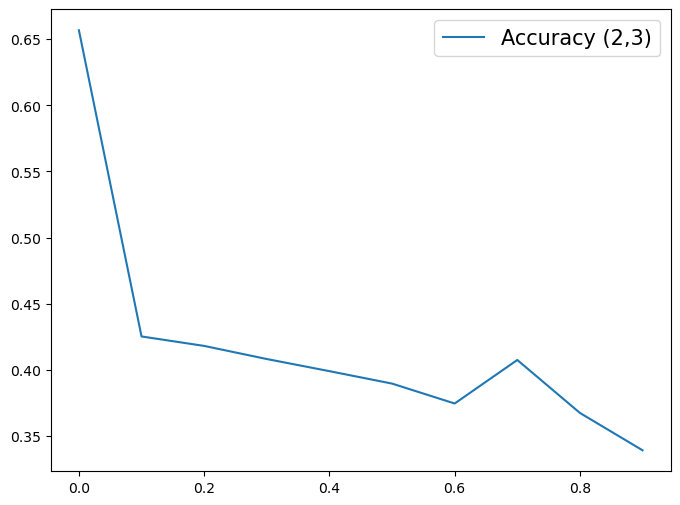

In [57]:
plt.figure(figsize=(8,6))
plt.plot(pis,accs,label='Accuracy (2,3)')
# plt.plot(pis,aucs,label='ROC AUC (2,3)')
plt.legend(fontsize=15)

In [5]:
_, _, R_G, R_H, testset=format_system({'pfi':0.3,'graphs':G,'left':2,'right':3,'largest_component':False})

In [33]:
test=list(testset.values())
between_results=[]
BG,BH=nx.edge_betweenness_centrality(R_G),nx.edge_betweenness_centrality(R_H)
for e in testset:
    try:
        bG=BG[e]
        bH=BH[e]
    except:
        bG=BG[(e[1],e[0])]
        bH=BH[(e[1],e[0])]
    if bG>bH:
        between_results.append(1)
    else:
        between_results.append(0)

In [34]:
accuracy_score(list(testset.values()),between_results)

0.9550561797752809

In [ ]:
pm,hm=set_parameters_N2V()
G_=N2V(R_G,pm,hm)
H_=N2V(R_H,pm,hm)

In [ ]:
[a,b,c]=reconstruct_system(testset, G, H, G_, H_, {'metric':'logistic'})

# Error Analysis

In [118]:
i,j=1,77
print(R_G.degree(i),R_G.degree(j),R_H.degree(i),R_H.degree(j))
print(np.linalg.norm(G_[i] - G_[j]),np.linalg.norm(H_[i] - H_[j]))

4 2 3 2
9.604995838089977e-05 3.454175966527893e-15


In [ ]:
testset

# Average Distance Scaling with Number of Edges

In [13]:
gs=[nx.grid_2d_graph(i,i,periodic=True) for i in range(5,20)]
gs=[nx.convert_node_labels_to_integers(gs[i]) for i in range(15)]
for i in range(15):
    gs[i].add_nodes_from(list(range(int(i*i),400)))

In [ ]:
avg_neighbor_distance=[]
for net in gs:
    avg=[]
    pm,hm=set_parameters_N2V(dimensions=128)
    e=N2V(net,pm,hm)
    for ed in net.edges():
        avg.append(np.linalg.norm(e[ed[0]] - e[ed[1]]))
    avg_neighbor_distance.append(np.mean(avg))

plt.plot([g.number_of_edges() for g in gs],[i for i in avg_neighbor_distance],'^--r')
plt.xlabel('Number of Edges',fontsize=15)
plt.ylabel('Average Distance (neighbors)',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

In [ ]:
plt.plot([g.number_of_edges() for g in gs],[i for i in avg_neighbor_distance],'^--r')
plt.xlabel('Number of Edges',fontsize=15)
plt.ylabel('Average Distance (neighbors)',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

In [ ]:
gs=[nx.gnm_random_graph(100,i) for i in range(200,400,20)]
gs=[nx.convert_node_labels_to_integers(gs[i]) for i in range(len(range(200,400,20)))]

avg_neighbor_distance=[]
for net in gs:
    avg=[]
    pm,hm=set_parameters_N2V(dimensions=128)
    e=N2V(net,pm,hm)
    for ed in net.edges():
        avg.append(np.linalg.norm(e[ed[0]] - e[ed[1]]))
    avg_neighbor_distance.append(np.mean(avg))

plt.plot([g.number_of_edges() for g in gs],[i for i in avg_neighbor_distance],'^--r')
plt.xlabel('Number of Edges',fontsize=15)
plt.ylabel('Average Distance (neighbors)',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

## SP Logistic Regression Exploration

In [3]:
# --- Scientific computing ---
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# ========== FUNCTIONS ==========
# --- Model training ---
def train_fit_logreg(X_train, y_train, seed=37):
    model = LogisticRegression(random_state=seed)
    model.fit(X_train, y_train)

    return model

def get_model_fit(model):
    return model.intercept_[0], model.coef_

# --- Reconstruction ---
def get_reconstruction(model, X_test):
    return model.predict(X_test)

def get_scores(model, X_test, class_label=1):
    # class_label = 1 indicates scoring for classification in G.
    return model.predict_proba(X_test)[:, class_label]

# --- Performance measures ---
def get_model_accuracy(model, X_test, y_test):
    return model.score(X_test, y_test)

def get_model_auroc(model, X_test, y_test):
    scores = get_scores(model, X_test)
    return roc_auc_score(y_test, scores)


# --- Helpers ---
def prepare_feature_matrix(
    distances_G, distances_H,
    degrees_i_G, degrees_i_H,
    degrees_j_G, degrees_j_H
):
    # >>> Book-keeping >>>
    NUM_FEATURES = 6  # number of features
    length = len(distances_G)  # number of observations in dataset
    feature_matrix = np.empty((length, NUM_FEATURES))  # initialize feature matrix
    # <<< Book-keeping <<<

    # >>> Format feature matrix >>>
    feature_matrix[:, 0] = distances_G
    feature_matrix[:, 1] = distances_H
    feature_matrix[:, 2] = degrees_i_G
    feature_matrix[:, 3] = degrees_i_H
    feature_matrix[:, 4] = degrees_j_G
    feature_matrix[:, 5] = degrees_j_H
    # <<< Format feature matrix <<<

    return feature_matrix

In [39]:
#create train and test for logreg
path='/Users/siddharthpatwardhan/Downloads/Archived/MRP_Figures/Figure4/Data/multiplex_network-'
G=read_file(path+'london'+'.edgelist')
g, h, R_G, R_H, testset=format_system({'pfi':0.3,'graphs':G,'left':1,'right':2,'largest_component':False})
EG=set(R_G.edges())
EH=set(R_H.edges())
EGL=list(R_G.edges())
EHL=list(R_H.edges())

trainset={(i,j):1 for (i,j) in EGL if (i,j) not in EH}
trainset.update({(i,j):0 for (i,j) in EHL if (i,j) not in EG})

pm,hm=set_parameters_N2V()
E1=N2V_per_component(R_G,pm,hm)
E2=N2V_per_component(R_H,pm,hm)

In [ ]:
#F1
def degree_ratio(r1,r2,i,j,norm=True):
    try:
        r=(r1.degree(i)*r1.degree(j))/(r2.degree(i)*r2.degree(j))
    except:
        r=r1.degree(i)*r1.degree(j)/0.0001
    if norm:
        return 2*r-1
    else:
        return r

def degree_g1(r1,r2,i,j,norm=True):
    return r1.degree(i)
def degree_g2(r1,r2,i,j,norm=True):
    return r1.degree(j)
def degree_h1(r1,r2,i,j,norm=True):
    return r2.degree(i)
def degree_h2(r1,r2,i,j,norm=True):
    return r2.degree(j)



#F3
def dist_ratio(r1,r2,i,j,norm=True):
    r=np.linalg.norm(E1[i] - E1[j])/(np.linalg.norm(E2[i] - E2[j])+1e-6)
    if norm==True:
        return 2*r-1
    else:
        return r




norm=True

print('Model 1: combined degrees')
features=[degree_ratio,dist_ratio]
xtr,ytr=np.zeros((len(trainset),len(features))),np.zeros(len(trainset))
for n,e in enumerate(trainset):
    for f in range(len(features)):
        xtr[n][f]=features[f](R_G,R_H,e[0],e[1],norm=norm)
        ytr[n]=trainset[e]
# for f in range(len(features)):
#     m,s=np.mean(xtr[:,f]),np.std(xtr[:,f])
#     xtr[:,f]=np.asarray([(i-m)/s for i in xtr[:,f]])
xts,yts=np.zeros((len(testset),len(features))),np.zeros(len(testset))
for n,e in enumerate(testset):
    for f in range(len(features)):
        xts[n][f]=features[f](R_G,R_H,e[0],e[1],norm=norm)
        yts[n]=testset[e]
# for f in range(len(features)):
#     m,s=np.mean(xts[:,f]),np.std(xts[:,f])
#     xts[:,f]=np.asarray([(i-m)/s for i in xts[:,f]])
model=train_fit_logreg(xtr,ytr)
print('Model',get_model_fit(model))
print('Accuracy:',get_model_accuracy(model,xts,yts))
print('AUROC:',get_model_auroc(model,xts,yts))




In [ ]:
tr1=[x[0] for i,x in enumerate(xtr) if ytr[i]==0]
tr2=[x[0] for i,x in enumerate(xtr) if ytr[i]==1]

plt.hist(tr2)

In [9]:
def full_model_results(net='london',layers=[2,3],per_component=True):
    accs,aucs=[],[]
    #create train and test for logreg
    path='/Users/siddharthpatwardhan/Downloads/Archived/MRP_Figures/Figure4/Data/multiplex_network-'
    G=read_file(path+net+'.edgelist')
    pis=np.linspace(0.1,0.7,5)
    for pi in pis:    
        g, h, R_G, R_H, testset=format_system({'pfi':pi,'graphs':G,'left':layers[0],'right':layers[1],'largest_component':False})
        EG=set(R_G.edges())
        EH=set(R_H.edges())
        EGL=list(R_G.edges())
        EHL=list(R_H.edges())

        trainset={(i,j):1 for (i,j) in EGL if (i,j) not in EH}
        trainset.update({(i,j):0 for (i,j) in EHL if (i,j) not in EG})

        pm,hm=set_parameters_N2V()
        if per_component:
            E1=N2V_normalized_per_component(R_G,pm,hm)
            E2=N2V_normalized_per_component(R_H,pm,hm)
        else:
            E1=N2V(R_G,pm,hm)
            E2=N2V(R_H,pm,hm)
        # print('Model 1: combined degrees')
        features=['distance']
        xtr,ytr=np.zeros((len(trainset),len(features))),np.zeros(len(trainset))
        for n,e in enumerate(trainset):
            i,j=e[0],e[1]
            r=R_G.degree(i)*R_G.degree(j)/(R_H.degree(i)*R_H.degree(j)+0.001)
            # d=np.linalg.norm(E1[i] - E1[j])/(np.linalg.norm(E2[i] - E2[j])+1e-6)
            a,b=np.linalg.norm(E1[i] - E1[j]),(np.linalg.norm(E2[i] - E2[j]))
            xtr[n][0]=2*b/(a+b)-1
            # xtr[n][1]=2*d-1
            ytr[n]=trainset[e]

        xts,yts=np.zeros((len(testset),len(features))),np.zeros(len(testset))
        for n,e in enumerate(testset):
            i,j=e[0],e[1]
            r=R_G.degree(i)*R_G.degree(j)/(R_H.degree(i)*R_H.degree(j)+0.001)
            # d=np.linalg.norm(E1[i] - E1[j])/(np.linalg.norm(E2[i] - E2[j])+1e-6)
            a,b=np.linalg.norm(E1[i] - E1[j]),(np.linalg.norm(E2[i] - E2[j]))
            xts[n][0]=2*b/(a+b)-1
            # xts[n][0]=2*r-1
            # xts[n][0]=d
            yts[n]=testset[e]

        model=train_fit_logreg(xtr,ytr)
        print('Model',get_model_fit(model))
        print('Accuracy:',get_model_accuracy(model,xts,yts))
        print('AUROC:',get_model_auroc(model,xts,yts))
        aucs.append(get_model_auroc(model,xts,yts))
        accs.append(get_model_accuracy(model,xts,yts))
        
    return aucs,accs


        

In [ ]:


AUC=np.zeros(5)
ACC=np.zeros(5)
for _ in range(2):
    aucs,accs=full_model_results(layers=[1,2])
    AUC=AUC+np.asarray(aucs)
    ACC=ACC+np.asarray(accs)
AUC=AUC/2
ACC=ACC/2

AUC_=np.zeros(5)
ACC_=np.zeros(5)
for _ in range(2):
    aucs,accs=full_model_results(layers=[1,2],per_component=False)
    AUC_=AUC_+np.asarray(aucs)
    ACC_=ACC_+np.asarray(accs)
AUC_=AUC_/2
ACC_=ACC_/2

plt.plot(np.linspace(0.1,0.7,5),AUC,'>-',label='Scaled per-component')
plt.plot(np.linspace(0.1,0.7,5),AUC_,'s-',label='Node2Vec')
# 
# plt.ylim(0.5,1.01)
plt.xlabel('Partial Information',fontsize=15)
plt.ylabel('AUROC',fontsize=15)
plt.legend(fontsize=13)
plt.title('London: Layers 1 and 2',fontsize=15)

Text(0.5, 1.0, 'London: Layers 2 and 3')

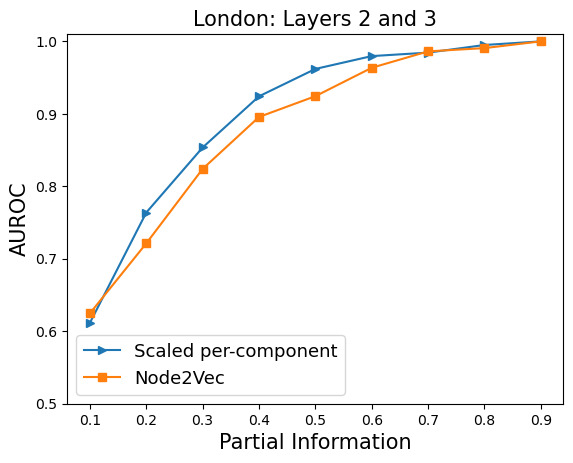

In [67]:
plt.plot(np.linspace(0.1,0.9,9),AUC,'>-',label='Scaled per-component')
plt.plot(np.linspace(0.1,0.9,9),AUC_,'s-',label='Node2Vec')

plt.ylim(0.5,1.01)
plt.xlabel('Partial Information',fontsize=15)
plt.ylabel('AUROC',fontsize=15)
plt.legend(fontsize=13)
plt.title('London: Layers 2 and 3',fontsize=15)

# SP node2vec scaled per component

In [28]:

G=nx.erdos_renyi_graph(100,0.015)



In [4]:
'''
This function takes a graph, parameters and hyperparameters as input and returns a mapping of nodes to their embedded vectors.
The function performs the following steps:

1. Initializes two empty data structures: 
vectors_per_component and vectors
2. Retrieves each component as a graph and stores them in a list sorted by size in descending order
3. Embeds each component by themselves using the N2V function
4. Scales the results of each component by the average norm of the largest component
5. Amalgamates the results by mapping each node to its embedded vector
6. Finally, the function returns the mapping of nodes to their embedded vectors.

Thank ChatGPT for this! :D 
'''

def N2V_normalized_per_component(graph, parameters, hyperparameters):
    vectors_per_component = []  # list of vector embeddings, canonical ordering
    vectors = {}  # amalgamated mapping of nodes to their embedded vectors (by component)
    # Retrieve each component as a graph
    component_subgraphs = sorted([ graph.subgraph(component).copy() for component in nx.connected_components(graph)], key=len,reverse=True)
    # Embed each component by themselves
    for component_subgraph in component_subgraphs:
        vectors_per_component.append(N2V(component_subgraph, parameters, hyperparameters))
    #scale results
    average_norm_gcc=np.mean([np.linalg.norm(i) for i in vectors_per_component[0].values()])
    for n,component_subgraph in enumerate(vectors_per_component[1:]):
        average_norm_multiplier=average_norm_gcc/np.mean([np.linalg.norm(i) for i in component_subgraph.values()])
        for node, vector in component_subgraph.items():
            component_subgraph[node]=average_norm_multiplier*vector
    # Amalgamate results
    for component_vectors in vectors_per_component:
        for node, vector in component_vectors.items():
            vectors[node] = vector
    return vectors



In [23]:
path='/Users/siddharthpatwardhan/Downloads/Archived/MRP_Figures/Figure4/Data/multiplex_network-'
G=read_file(path+'london'+'.edgelist')
g, h, R_G, R_H, testset=format_system({'pfi':0.5,'graphs':G,'left':1,'right':2,'largest_component':False})
EG=set(R_G.edges())
EH=set(R_H.edges())
EGL=list(R_G.edges())
EHL=list(R_H.edges())

pm,hm=set_parameters_N2V()
E1=N2V(R_H,pm,hm)
E2=N2V_normalized(R_H,pm,hm)

In [ ]:
AUC=np.zeros(9)
ACC=np.zeros(9)
for _ in range(2):
    aucs,accs=full_model_results(layers=[2,3],)
    AUC=AUC+np.asarray(aucs)
    ACC=ACC+np.asarray(accs)
AUC=AUC/2
ACC=ACC/2

AUC_=np.zeros(9)
ACC_=np.zeros(9)
for _ in range(2):
    aucs,accs=full_model_results(layers=[2,3],per_component=False)
    AUC_=AUC_+np.asarray(aucs)
    ACC_=ACC_+np.asarray(accs)
AUC_=AUC_/2
ACC_=ACC_/2

plt.plot(np.linspace(0.1,0.9,9),AUC,'>-',label='Scaled per-component')
plt.plot(np.linspace(0.1,0.9,9),AUC_,'s-',label='Node2Vec')

# plt.ylim(0.5,1.01)
plt.xlabel('Partial Information',fontsize=15)
plt.ylabel('AUROC',fontsize=15)
plt.legend(fontsize=13)
plt.title('London: Layers 2 and 3 (embeddings only)',fontsize=15)

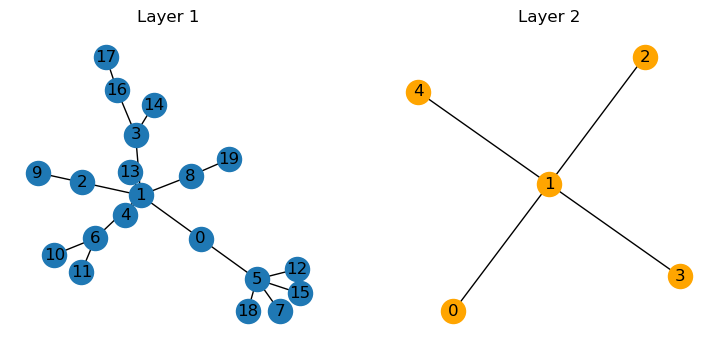

In [119]:
g1=nx.barabasi_albert_graph(20,1)
g2=nx.barabasi_albert_graph(5,1)
fig=plt.figure(figsize=(9,4))
ax1=fig.add_subplot(121)

plt.title('Layer 1')
nx.draw(g1,with_labels=True)
ax2=fig.add_subplot(122)
plt.title('Layer 2')
nx.draw(g2,node_color='orange',with_labels=True)

In [117]:
def N2V_normalized(graph, parameters, hyperparameters):
    '''
    This code is used to normalize the node embeddings of a graph using the Node2Vec algorithm. 
    1. It takes a graph, parameters, and hyperparameters as input. First, it calculates the node embeddings using the Node2Vec algorithm and stores them in the variable X. 
    2. Then, it sorts the connected components of the graph in descending order based on their size. 
    3. It calculates the average norm of the nodes in the largest connected component (GCC) and stores it in the variable 
    average_norm_gcc. 
    4. For the remaining components, it calculates the average norm of the nodes and divides it by the average norm of the nodes in the GCC. 
    5. Finally, it multiplies each node embedding in the component by the average norm multiplier and stores the normalized embeddings in the variable X.
    '''
    X=N2V(graph, parameters, hyperparameters)
    component_subgraphs = sorted([ graph.subgraph(component).copy() for component in nx.connected_components(graph)], key=len,reverse=True)
    average_norm_gcc=np.mean([np.linalg.norm(X[i]) for i in component_subgraphs[0].nodes()])
    for component_subgraph in component_subgraphs[1:]:
        average_norm_multiplier=average_norm_gcc/np.mean([np.linalg.norm(X[i]) for i in component_subgraph.nodes()])
        for n,node in enumerate(component_subgraph.nodes()):
            X[node]=average_norm_multiplier*X[node]+n*10
    return X


g=nx.planted_partition_graph(2,50,0.1,0)
component_subgraphs = sorted([ g.subgraph(component).copy() for component in nx.connected_components(g)], key=len,reverse=True)
print([len(i) for i in component_subgraphs])
pm,hm=set_parameters_N2V()

[50, 50]


In [118]:
path='/Users/siddharthpatwardhan/Downloads/Archived/MRP_Figures/Figure4/Data/multiplex_network-'
G=read_file(path+'london'+'.edgelist')

g, h, R_G, R_H, testset=format_system({'pfi':0.3,'graphs':G,'left':1,'right':2,'largest_component':False})
EG=set(R_G.edges())
EH=set(R_H.edges())
EGL=list(R_G.edges())
EHL=list(R_H.edges())

pm,hm=set_parameters_N2V()
# E=N2V_normalized_per_component(R_H,pm,hm)

In [119]:
#create train and test for logreg
net='london'
path='/Users/siddharthpatwardhan/Downloads/Archived/MRP_Figures/Figure4/Data/multiplex_network-'
G=read_file(path+net+'.edgelist')
pis=np.linspace(0.1,0.7,5)

for pi in pis[3:4]:    
    g, h, R_G, R_H, testset=format_system({'pfi':pi,'graphs':G,'left':1,'right':2,'largest_component':False})
    EG=set(R_G.edges())
    EH=set(R_H.edges())
    EGL=list(R_G.edges())
    EHL=list(R_H.edges())

    trainset={(i,j):1 for (i,j) in EGL if (i,j) not in EH}
    trainset.update({(i,j):0 for (i,j) in EHL if (i,j) not in EG})

    pm,hm=set_parameters_N2V()
    E1=N2V_normalized(R_G,pm,hm)
    E2=N2V_normalized(R_H,pm,hm)
    features=['f1','f2']
    xtr,ytr=np.zeros((len(trainset),len(features))),np.zeros(len(trainset))
    for n,e in enumerate(trainset):
        i,j=e[0],e[1]
        r=R_G.degree(i)*R_G.degree(j)/(R_H.degree(i)*R_H.degree(j)+0.001)
        d=np.linalg.norm(E1[i] - E1[j])/(np.linalg.norm(E2[i] - E2[j])+1e-6)
        a,b=np.linalg.norm(E1[i] - E1[j]),(np.linalg.norm(E2[i] - E2[j]))
        xtr[n][0]=b/(a+b)
        xtr[n][1]=d
        ytr[n]=trainset[e]

    xts,yts=np.zeros((len(testset),len(features))),np.zeros(len(testset))
    for n,e in enumerate(testset):
        i,j=e[0],e[1]
        r=R_G.degree(i)*R_G.degree(j)/(R_H.degree(i)*R_H.degree(j)+0.001)
        d=np.linalg.norm(E1[i] - E1[j])/(np.linalg.norm(E2[i] - E2[j])+1e-6)
        a,b=np.linalg.norm(E1[i] - E1[j]),(np.linalg.norm(E2[i] - E2[j]))
        xts[n][0]=b/(a+b)
        xts[n][1]=d
        yts[n]=testset[e]


In [120]:
model=train_fit_logreg(xtr[:,1].reshape(-1,1),ytr)
print('Model with distance ratios: ',get_model_fit(model))
print('AUROC:',get_model_auroc(model,xts[:,1].reshape(-1,1),yts))


model=train_fit_logreg(xtr[:,0].reshape(-1,1),ytr)
print('Model with configuration model-like feature: ',get_model_fit(model))
print('AUROC:',get_model_auroc(model,xts[:,0].reshape(-1,1),yts))


model=train_fit_logreg(xtr,ytr)
print('Model both: ',get_model_fit(model))
print('AUROC:',get_model_auroc(model,xts,yts))


Model with distance ratios:  (3.349840682163691, array([[-1.88694949]]))
AUROC: 0.9528169014084508
Model with configuration model-like feature:  (-1.9606963122197785, array([[4.93248951]]))
AUROC: 0.9528169014084508
Model both:  (3.2174385714938687, array([[ 0.14895343, -1.86060589]]))
AUROC: 0.9528169014084508


(array([30.,  4.,  6.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([9.76102896e-03, 4.02551063e+01, 8.05004516e+01, 1.20745797e+02,
        1.60991142e+02, 2.01236487e+02, 2.41481833e+02, 2.81727178e+02,
        3.21972523e+02, 3.62217869e+02, 4.02463214e+02]),
 <BarContainer object of 10 artists>)

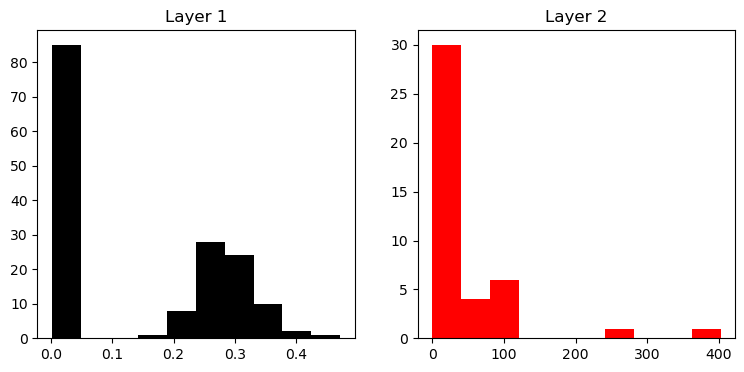

In [121]:
fig=plt.figure(figsize=(9,4))
ax1=fig.add_subplot(121)

plt.title('Layer 1')
plt.hist(xtr[:list(ytr).count(1),1],color='k')
ax2=fig.add_subplot(122)
plt.title('Layer 2')
plt.hist(xtr[list(ytr).count(1):,1],color='r')


(array([12.,  8., 12.,  0.,  1.,  0.,  0.,  0.,  0.,  4.]),
 array([4.10870474e-04, 1.00214942e-01, 2.00019014e-01, 2.99823086e-01,
        3.99627158e-01, 4.99431231e-01, 5.99235303e-01, 6.99039375e-01,
        7.98843447e-01, 8.98647519e-01, 9.98451591e-01]),
 <BarContainer object of 10 artists>)

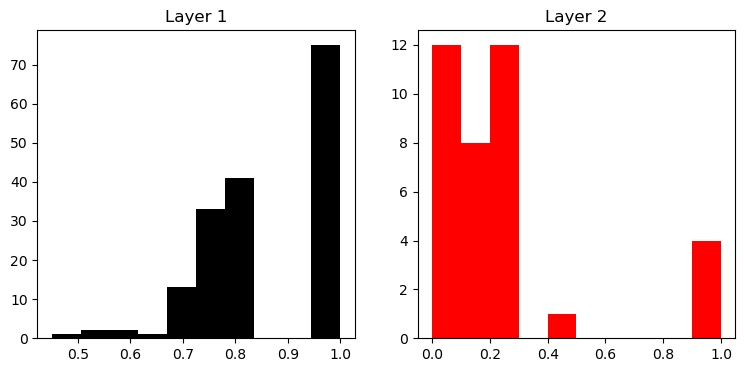

In [115]:
fig=plt.figure(figsize=(9,4))
ax1=fig.add_subplot(121)

plt.title('Layer 1')
plt.hist(xtr[:list(ytr).count(1),0],color='k')
ax2=fig.add_subplot(122)
plt.title('Layer 2')
plt.hist(xtr[list(ytr).count(1):,0],color='r')

Many variants: London 1-2 analysis with the following settings


Settings to consider: 

1. Per component 
2. normalization 
3. displacement


In [168]:
def N2V_custom(graph, parameters, hyperparameters, per_component=True,normalize=True,displace=True):

    component_subgraphs = sorted([ graph.subgraph(component).copy() for component in nx.connected_components(graph)], key=len,reverse=True)
    if not per_component:
        X=N2V(graph, parameters, hyperparameters)
        if not normalize and not displace:
            return X
        
        elif normalize and not displace:
        
            average_norm_gcc=np.mean([np.linalg.norm(X[i]) for i in component_subgraphs[0].nodes()])
            for component_subgraph in component_subgraphs[1:]:
                average_norm_multiplier=average_norm_gcc/np.mean([np.linalg.norm(X[i]) for i in component_subgraph.nodes()])
                for n,node in enumerate(component_subgraph.nodes()):
                    X[node]=average_norm_multiplier*X[node]
            return X
        elif normalize and displace:
        
            average_norm_gcc=np.mean([np.linalg.norm(X[i]) for i in component_subgraphs[0].nodes()])
            for component_subgraph in component_subgraphs[1:]:
                average_norm_multiplier=average_norm_gcc/np.mean([np.linalg.norm(X[i]) for i in component_subgraph.nodes()])
                for n,node in enumerate(component_subgraph.nodes()):
                    X[node]=average_norm_multiplier*X[node]+n*10
            return X
        elif not normalize and displace:
            for component_subgraph in component_subgraphs[1:]:
                for n,node in enumerate(component_subgraph.nodes()):
                    X[node]=X[node]+n*10
            return X


    else:
        vectors_per_component=[]
        X={}
        if normalize and not displace:
            for component_subgraph in component_subgraphs:
                vectors_per_component.append(N2V(component_subgraph, parameters, hyperparameters))
            #scale results
            average_norm_gcc=np.mean([np.linalg.norm(i) for i in vectors_per_component[0].values()])
            for n,component_subgraph in enumerate(vectors_per_component[1:]):
                average_norm_multiplier=average_norm_gcc/np.mean([np.linalg.norm(i) for i in component_subgraph.values()])
                for node, vector in component_subgraph.items():
                    component_subgraph[node]=average_norm_multiplier*vector
            # Amalgamate results
            for component_vectors in vectors_per_component:
                for node, vector in component_vectors.items():
                    X[node] = vector
            return X
            


        elif normalize and displace:
            for component_subgraph in component_subgraphs:
                vectors_per_component.append(N2V(component_subgraph, parameters, hyperparameters))
            #scale results
            average_norm_gcc=np.mean([np.linalg.norm(i) for i in vectors_per_component[0].values()])
            for n,component_subgraph in enumerate(vectors_per_component[1:]):
                average_norm_multiplier=average_norm_gcc/np.mean([np.linalg.norm(i) for i in component_subgraph.values()])
                for node, vector in component_subgraph.items():
                    component_subgraph[node]=average_norm_multiplier*vector +n*10
            # Amalgamate results
            for component_vectors in vectors_per_component:
                for node, vector in component_vectors.items():
                    X[node] = vector
            return X

        elif not normalize and displace:
            for component_subgraph in component_subgraphs:
                vectors_per_component.append(N2V(component_subgraph, parameters, hyperparameters))
            #scale results
            average_norm_gcc=np.mean([np.linalg.norm(i) for i in vectors_per_component[0].values()])
            for n,component_subgraph in enumerate(vectors_per_component[1:]):
                average_norm_multiplier=average_norm_gcc/np.mean([np.linalg.norm(i) for i in component_subgraph.values()])
                for node, vector in component_subgraph.items():
                    component_subgraph[node]=vector+n*10
            # Amalgamate results
            for component_vectors in vectors_per_component:
                for node, vector in component_vectors.items():
                    X[node] = vector
            return X


        else:
            for component_subgraph in component_subgraphs:
                vectors_per_component.append(N2V(component_subgraph, parameters, hyperparameters))
            #scale results
            average_norm_gcc=np.mean([np.linalg.norm(i) for i in vectors_per_component[0].values()])
            for n,component_subgraph in enumerate(vectors_per_component[1:]):
                average_norm_multiplier=average_norm_gcc/np.mean([np.linalg.norm(i) for i in component_subgraph.values()])
                for node, vector in component_subgraph.items():
                    component_subgraph[node]=vector
            # Amalgamate results
            for component_vectors in vectors_per_component:
                for node, vector in component_vectors.items():
                    X[node] = vector
            return X


def full_model_results(net='london',layers=[1,2],per_component=True,normalize=True,displace=True):
    accs_r,aucs_r=[],[]
    accs_c,aucs_c=[],[]
    
    #create train and test for logreg
    path='/Users/siddharthpatwardhan/Downloads/Archived/MRP_Figures/Figure4/Data/multiplex_network-'
    G=read_file(path+net+'.edgelist')
    pis=np.linspace(0.1,0.9,5)
    for pi in pis:    
        g, h, R_G, R_H, testset=format_system({'pfi':pi,'graphs':G,'left':layers[0],'right':layers[1],'largest_component':False})
        EG=set(R_G.edges())
        EH=set(R_H.edges())
        EGL=list(R_G.edges())
        EHL=list(R_H.edges())

        trainset={(i,j):1 for (i,j) in EGL if (i,j) not in EH}
        trainset.update({(i,j):0 for (i,j) in EHL if (i,j) not in EG})

        pm,hm=set_parameters_N2V(workers=10)
        E1=N2V_custom(R_G,pm,hm,per_component=per_component,normalize=normalize,displace=displace)
        E2=N2V_custom(R_H,pm,hm,per_component=per_component,normalize=normalize,displace=displace)

        # print('Model 1: combined degrees')
        features=['ratios','conf']
        xtr,ytr=np.zeros((len(trainset),len(features))),np.zeros(len(trainset))
        for n,e in enumerate(trainset):
            i,j=e[0],e[1]
            r=R_G.degree(i)*R_G.degree(j)/(R_H.degree(i)*R_H.degree(j)+0.001)
            d=np.linalg.norm(E1[i] - E1[j])/(np.linalg.norm(E2[i] - E2[j])+1e-6)
            a,b=np.linalg.norm(E1[i] - E1[j]),(np.linalg.norm(E2[i] - E2[j]))
            xtr[n][1]=2*(b)/(a+b)-1
            xtr[n][0]=d
            # xtr[n][2]=r
            
            ytr[n]=trainset[e]

        xts,yts=np.zeros((len(testset),len(features))),np.zeros(len(testset))
        for n,e in enumerate(testset):
            i,j=e[0],e[1]
            r=R_G.degree(i)*R_G.degree(j)/(R_H.degree(i)*R_H.degree(j)+0.001)
            d=np.linalg.norm(E1[i] - E1[j])/(np.linalg.norm(E2[i] - E2[j])+1e-6)
            a,b=np.linalg.norm(E1[i] - E1[j]),(np.linalg.norm(E2[i] - E2[j]))
            xts[n][1]=2*(b)/(a+b)-1
            xts[n][0]=d
            yts[n]=testset[e]

        model=train_fit_logreg(xtr[:,0].reshape(-1,1),ytr)
        print('Model with distance ratios: ',get_model_fit(model))
        auc=get_model_auroc(model,xts[:,0].reshape(-1,1),yts)
        print('AUROC:',auc)
        print(get_model_accuracy(model,xts[:,0].reshape(-1,1),yts))
        aucs_r.append(auc)

        model_=train_fit_logreg(xtr[:,1].reshape(-1,1),ytr)
        print('Model with conf-like: ',get_model_fit(model_))
        auc=get_model_auroc(model_,xts[:,1].reshape(-1,1),yts)
        print(get_model_accuracy(model_,xts[:,1].reshape(-1,1),yts))
        print('AUROC:',auc)
        aucs_c.append(auc)
        
    return aucs_c,aucs_r


## Vanilla Node2Vec

In [160]:
AUCS_C,AUCS_R=full_model_results(per_component=False,normalize=False,displace=False)

Model with distance ratios:  (4.3920144522749816, array([[-1.87376094]]))
AUROC: 0.2880434782608695
0.7976539589442815
Model with conf-like:  (1.7473533725416817, array([[1.88421226]]))
0.7976539589442815
AUROC: 0.2880434782608695
Model with distance ratios:  (1.4739894394067015, array([[-0.08523941]]))
AUROC: 0.13163636363636366
0.8111111111111111
Model with conf-like:  (1.1742606728405325, array([[2.95343135]]))
0.8074074074074075
AUROC: 0.13163636363636366
Model with distance ratios:  (1.3846475376508232, array([[-0.01627177]]))
AUROC: 0.0517760385310054
0.8206521739130435
Model with conf-like:  (1.172872074326377, array([[1.6491457]]))
0.8206521739130435
AUROC: 0.0517760385310054
Model with distance ratios:  (1.1167337237696189, array([[0.08795812]]))
AUROC: 0.9086069210292813
0.8099173553719008
Model with conf-like:  (1.4270246291216202, array([[-0.05989641]]))
0.8099173553719008
AUROC: 0.9086069210292813
Model with distance ratios:  (0.18382924240782192, array([[0.19672107]]))
AU

Text(0.5, 1.0, 'London: Layers 1 and 2')

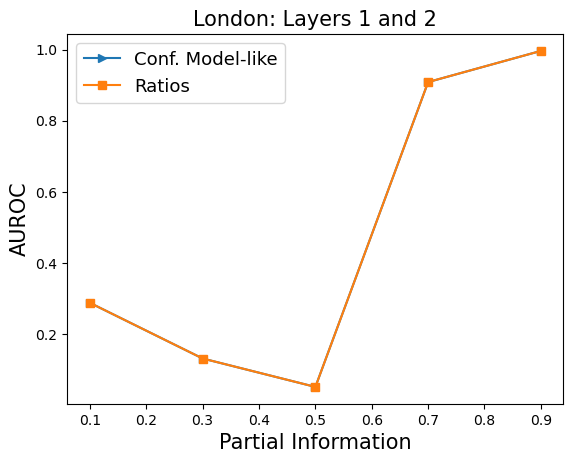

In [161]:
plt.plot(np.linspace(0.1,0.9,5),AUCS_C,'>-',label='Conf. Model-like')
plt.plot(np.linspace(0.1,0.9,5),AUCS_R,'s-',label='Ratios')

# plt.ylim(0.5,1.01)
plt.xlabel('Partial Information',fontsize=15)
plt.ylabel('AUROC',fontsize=15)
plt.legend(fontsize=13)
plt.title('London: Layers 1 and 2',fontsize=15)

## Node2Vec with Displacement

Model with distance ratios:  (0.28548611264314544, array([[1.67218269]]))
AUROC: 0.41410507957270554
Model with configuration model-like feature:  (3.3262042243743837, array([[-1.65067067]]))
AUROC: 0.41410507957270554
Model with distance ratios:  (-0.6688728401394266, array([[3.67849457]]))
AUROC: 0.5914570230607966
Model with configuration model-like feature:  (2.0695173794714274, array([[-0.13954365]]))
AUROC: 0.5914570230607966
Model with distance ratios:  (-0.3301155887145121, array([[3.03088037]]))
AUROC: 0.707218712192499
Model with configuration model-like feature:  (1.9715694766196996, array([[-0.0574262]]))
AUROC: 0.707218712192499
Model with distance ratios:  (0.010139127792410255, array([[2.36240247]]))
AUROC: 0.9358164983164983
Model with configuration model-like feature:  (1.8775283368226656, array([[-0.04357801]]))
AUROC: 0.9358164983164983
Model with distance ratios:  (1.1676975026798446, array([[0.72254568]]))
AUROC: 0.9200454717696097
Model with configuration model-li

Text(0.5, 1.0, 'London: Layers 1 and 2')

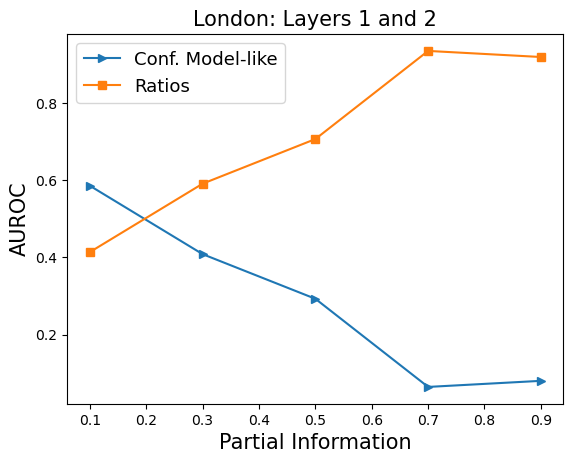

In [136]:
AUCS_C,AUCS_R=full_model_results(per_component=False,normalize=False,displace=True)
plt.plot(np.linspace(0.1,0.9,5),AUCS_C,'>-',label='Conf. Model-like')
plt.plot(np.linspace(0.1,0.9,5),AUCS_R,'s-',label='Ratios')

# plt.ylim(0.5,1.01)
plt.xlabel('Partial Information',fontsize=15)
plt.ylabel('AUROC',fontsize=15)
plt.legend(fontsize=13)
plt.title('London: Layers 1 and 2',fontsize=15)

## Node2Vec with Normalization

Model with distance ratios:  (3.958085890972011, array([[-1.93812308]]))
AUROC: 0.30763794509377546
0.8132183908045977
Model with conf-like:  (0.7689000463358239, array([[2.40886765]]))
0.8132183908045977
AUROC: 0.6923620549062246
Model with distance ratios:  (5.6701347907902555, array([[-2.53064231]]))
AUROC: 0.10719373219373218
0.7985074626865671
Model with conf-like:  (1.195842044059281, array([[4.19891229]]))
0.8059701492537313
AUROC: 0.8928062678062678
Model with distance ratios:  (5.963936841959304, array([[-2.80242147]]))
AUROC: 0.042036910457963095
0.7864583333333334
Model with conf-like:  (1.0697400262447838, array([[4.91789433]]))
0.8020833333333334
AUROC: 0.9579630895420369
Model with distance ratios:  (5.859948750552481, array([[-2.73054786]]))
AUROC: 0.03739837398373983
0.7525773195876289
Model with conf-like:  (1.0067771086133321, array([[5.44741334]]))
0.845360824742268
AUROC: 0.9626016260162602
Model with distance ratios:  (6.008956513939466, array([[-2.58916898]]))
AUR

Text(0.5, 1.0, 'London: Layers 1 and 2')

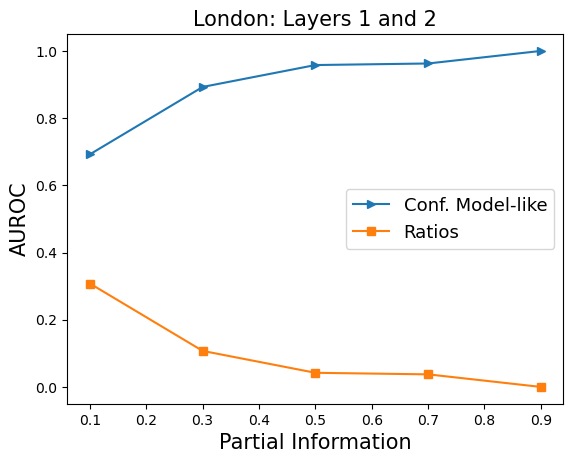

In [163]:
AUCS_C,AUCS_R=full_model_results(per_component=False,normalize=True,displace=False)
plt.plot(np.linspace(0.1,0.9,5),AUCS_C,'>-',label='Conf. Model-like')
plt.plot(np.linspace(0.1,0.9,5),AUCS_R,'s-',label='Ratios')

plt.xlabel('Partial Information',fontsize=15)
plt.ylabel('AUROC',fontsize=15)
plt.legend(fontsize=13)
plt.title('London: Layers 1 and 2',fontsize=15)

## Node2Vec with Per-component embedding

Model with distance ratios:  (0.06120332440113717, array([[2.28043748]]))
AUROC: 0.24809027777777776
Model with configuration model-like feature:  (4.579991920839447, array([[-2.15503946]]))
AUROC: 0.24809027777777776
Model with distance ratios:  (0.2686919672558719, array([[2.30368206]]))
AUROC: 0.12100580270793036
Model with configuration model-like feature:  (1.49577145885418, array([[-0.0707673]]))
AUROC: 0.12100580270793036


/Users/siddharthpatwardhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/siddharthpatwardhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Model with distance ratios:  (0.8335426662292101, array([[1.32650733]]))
AUROC: 0.044960474308300385
Model with configuration model-like feature:  (1.2736342424942002, array([[0.00092644]]))
AUROC: 0.9550395256916997
Model with distance ratios:  (1.5822800351935133, array([[-0.32234197]]))
AUROC: 0.9864081996434937
Model with configuration model-like feature:  (1.253694265993682, array([[0.00140042]]))
AUROC: 0.9864081996434937
Model with distance ratios:  (2.7059124290746834, array([[-3.0980319]]))
AUROC: 0.9726266744321491
Model with configuration model-like feature:  (0.7799553573304748, array([[0.1101954]]))
AUROC: 0.9726266744321491


Text(0.5, 1.0, 'London: Layers 1 and 2')

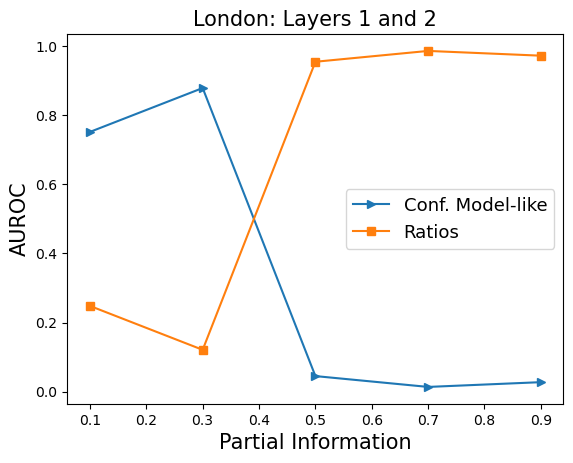

In [141]:
AUCS_C,AUCS_R=full_model_results(per_component=True,normalize=False,displace=False)
plt.plot(np.linspace(0.1,0.9,5),AUCS_C,'>-',label='Conf. Model-like')
plt.plot(np.linspace(0.1,0.9,5),AUCS_R,'s-',label='Ratios')

# plt.ylim(0.5,1.01)
plt.xlabel('Partial Information',fontsize=15)
plt.ylabel('AUROC',fontsize=15)
plt.legend(fontsize=13)
plt.title('London: Layers 1 and 2',fontsize=15)

## Percomponent and displaced

Model with distance ratios:  (-0.6201785742719486, array([[2.88992407]]))
AUROC: 0.2704898446833931
Model with configuration model-like feature:  (4.240604372440966, array([[-1.85059496]]))
AUROC: 0.2704898446833931
Model with distance ratios:  (-0.7005584712559552, array([[3.8970195]]))
AUROC: 0.14339981006647673
Model with configuration model-like feature:  (3.3910273889474514, array([[-0.6653769]]))
AUROC: 0.14339981006647673
Model with distance ratios:  (-1.2274036209912216, array([[4.6663313]]))
AUROC: 0.05155618911855547
Model with configuration model-like feature:  (5.305967824382723, array([[-1.91622167]]))
AUROC: 0.05155618911855547
Model with distance ratios:  (-1.5664170234831594, array([[5.23375702]]))
AUROC: 0.0024436600597339104
Model with configuration model-like feature:  (11.31709493150538, array([[-0.20450409]]))
AUROC: 0.0024436600597339104
Model with distance ratios:  (-1.892198682514739, array([[5.55729348]]))
AUROC: 0.04078014184397164
Model with configuration mod

Text(0.5, 1.0, 'London: Layers 1 and 2')

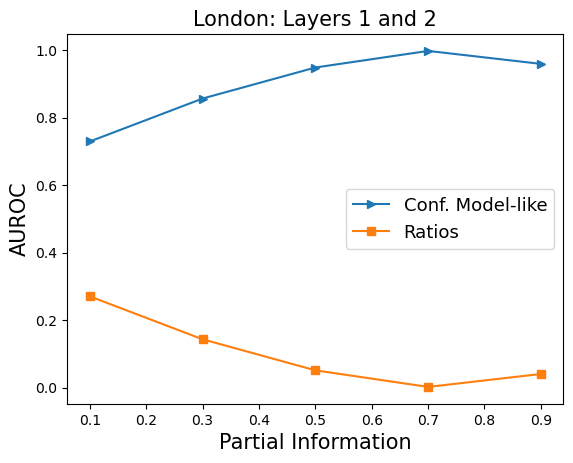

In [142]:
AUCS_C,AUCS_R=full_model_results(per_component=True,normalize=False,displace=True)
plt.plot(np.linspace(0.1,0.9,5),AUCS_C,'>-',label='Conf. Model-like')
plt.plot(np.linspace(0.1,0.9,5),AUCS_R,'s-',label='Ratios')

# plt.ylim(0.5,1.01)
plt.xlabel('Partial Information',fontsize=15)
plt.ylabel('AUROC',fontsize=15)
plt.legend(fontsize=13)
plt.title('London: Layers 1 and 2',fontsize=15)

## Per-component and Normalized

Model with distance ratios:  (4.827536706697763, array([[-1.92247821]]))
AUROC: 0.37163282813840426
0.7874251497005988
Model with conf-like:  (1.273827869045437, array([[2.69448428]]))
0.7904191616766467
AUROC: 0.37163282813840426
Model with distance ratios:  (1.2762895481301186, array([[8.61704776e-06]]))
AUROC: 0.80078125
0.8125
Model with conf-like:  (1.37032218137748, array([[2.38466477]]))
0.73828125
AUROC: 0.19921875


/Users/siddharthpatwardhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model with distance ratios:  (1.6005351201606985, array([[0.00029652]]))
AUROC: 0.897979797979798
0.7971014492753623
Model with conf-like:  (1.5059370281453144, array([[1.10438664]]))
0.7971014492753623
AUROC: 0.10202020202020202
Model with distance ratios:  (0.9279715555758218, array([[1.01671438e-05]]))
AUROC: 0.9972527472527473
0.832
Model with conf-like:  (1.3539841653527729, array([[0.01391087]]))
0.832
AUROC: 0.0027472527472527483
Model with distance ratios:  (0.0001313711629795922, array([[3.03078552e-05]]))
AUROC: 1.0
0.8
Model with conf-like:  (1.147069576215713, array([[-1.64793948]]))
0.8
AUROC: 1.0


/Users/siddharthpatwardhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.0, 'London: Layers 1 and 2')

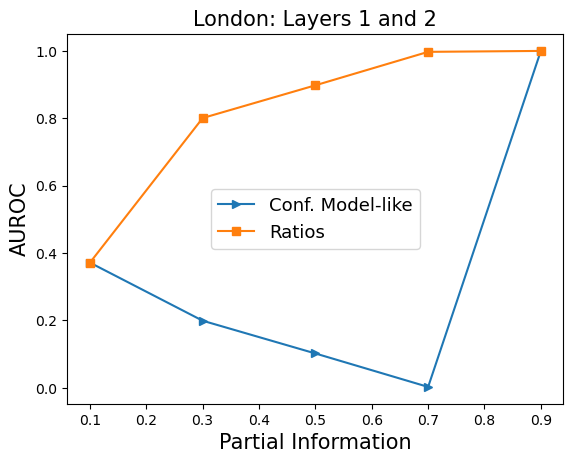

In [169]:
AUCS_C,AUCS_R=full_model_results(per_component=True,normalize=True,displace=False)
plt.plot(np.linspace(0.1,0.9,5),AUCS_C,'>-',label='Conf. Model-like')
plt.plot(np.linspace(0.1,0.9,5),AUCS_R,'s-',label='Ratios')

# plt.ylim(0.5,1.01)
plt.xlabel('Partial Information',fontsize=15)
plt.ylabel('AUROC',fontsize=15)
plt.legend(fontsize=13)
plt.title('London: Layers 1 and 2',fontsize=15)

## Percomponent, displaced, and normalized

Model with distance ratios:  (4.384113940342079, array([[-1.98340899]]))
AUROC: 0.31101190476190477
0.7685459940652819
Model with conf-like:  (0.9958902777291253, array([[2.60120762]]))
0.7685459940652819
AUROC: 0.31101190476190477
Model with distance ratios:  (5.008331941383237, array([[-1.60932924]]))
AUROC: 0.18329446315971323
0.7266187050359713
Model with conf-like:  (1.2752450475198067, array([[3.35322219]]))
0.7014388489208633
AUROC: 0.18329446315971323
Model with distance ratios:  (5.061905130752302, array([[-1.99379125]]))
AUROC: 0.04729064039408868
0.4222222222222222
Model with conf-like:  (1.1134676625017381, array([[3.80708401]]))
0.3611111111111111
AUROC: 0.04729064039408868
Model with distance ratios:  (5.261549102596563, array([[-2.2234889]]))
AUROC: 0.04234724742891713
0.27358490566037735
Model with conf-like:  (0.6462862155772583, array([[3.99819475]]))
0.16037735849056603
AUROC: 0.04234724742891713
Model with distance ratios:  (5.464505438273929, array([[-2.02882639]])

Text(0.5, 1.0, 'London: Layers 1 and 2')

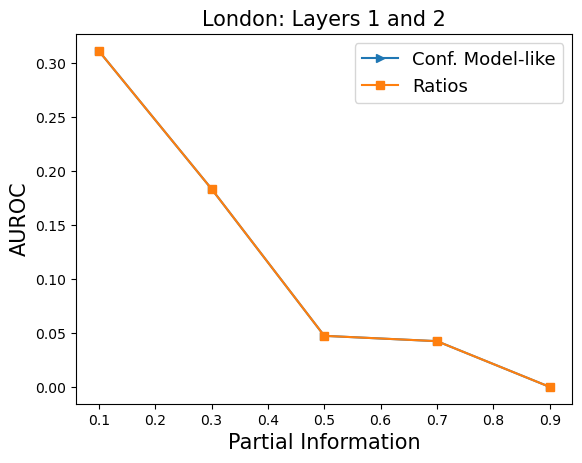

In [166]:
AUCS_C,AUCS_R=full_model_results(per_component=True,normalize=True,displace=True)
plt.plot(np.linspace(0.1,0.9,5),AUCS_C,'>-',label='Conf. Model-like')
plt.plot(np.linspace(0.1,0.9,5),AUCS_R,'s-',label='Ratios')

# plt.ylim(0.5,1.01)
plt.xlabel('Partial Information',fontsize=15)
plt.ylabel('AUROC',fontsize=15)
plt.legend(fontsize=13)
plt.title('London: Layers 1 and 2',fontsize=15)